## Lab 5: Species Distribution Modeling with Bagging 
Climate change and deforestation are accelerating ecosystem degradation, pushing animal species toward the brink of extinction. Understanding the distribution of animals and the factors that influence their ability to thrive in different environments is critical for conservation efforts. By studying these relationships, biological conservationists can develop informed strategies to protect endangered species and maintain biodiversity across diverse ecosystems.

Species are defined by their behavioral, physiological, and ecological attributes, which shape their roles in ecosystems. In turn, ecosystems and their functions are deeply influenced by the species that inhabit them. This reciprocal relationship makes evaluating species' functional diversity and distributions essential for research in biogeography, community ecology, macroevolution, and conservation. Functional diversity is determined by traits such as diet, foraging strata, trophic level, activity cycle, litter size, generation length, habitat breadth, and body mass. These traits influence an animal’s ability to survive and adapt to different climates, playing a crucial role in ecosystem stability.

In this lab, we will explore the connections between animal behaviors, functional traits, and species distributions across different climates.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.utils import resample

### Step 1: Standardizing column names

The dataset contains several columns that describe different aspects of bird diets. These column names currently include spaces, colons (:), and special characters, which can make them difficult to work with in code.

Load the dataset (BirdTraitData.csv) into a Pandas DataFrame.

The 7 column names that start with "Diet:" should be renamed to simpler version starting with `Diet_` in a way that conforms with this list of key variables:

`AdultBodyMass`, `DietBreadth`, `Diet_Invertebrates`, `Diet_Vertebrates`,`Diet_Fruits`, `Diet_Flowers`, `Diet_Seeds`, `Diet_Plants`, `Diet_Other`, `TrophicLevel`,`ActivityCycle`, `ForagingStratum`, `MigratoryStatus`,`IncubationTime`, `ClutchSize`, `EggLength`, `EggWidth`,`EggMass`, `NestingHabit`,`MaxLongevity`, `Subarid`

Then select only that list of 21 key variables. **Print the head of your dataframe.** 

In [2]:
birds = pd.read_csv("BirdTraitData.csv", encoding= "unicode_escape", na_values=[-999])

rename_dict = {
    'Diet: invertebrates': 'Diet_Invertebrates',
    'Diet: vertebrates': 'Diet_Vertebrates',
    'Diet: fruits': 'Diet_Fruits',
    'Diet: flower/nectar/pollen/gums': 'Diet_Flowers',
    'Diet: seeds': 'Diet_Seeds',
    'Diet: other plant materials': 'Diet_Plants',
    'Diet: scavenge; garbage; carrion; offal; carcasses': 'Diet_Other'
}

birds = birds.rename(columns=rename_dict)

selected_columns = [
    'AdultBodyMass', 
    'DietBreadth', 
    'Diet_Invertebrates', 
    'Diet_Vertebrates',
    'Diet_Fruits', 
    'Diet_Flowers', 
    'Diet_Seeds', 
    'Diet_Plants', 
    'Diet_Other', 
    'TrophicLevel',
    'ActivityCycle', 
    'ForagingStratum', 
    'MigratoryStatus',
    'IncubationTime', 
    'ClutchSize', 
    'EggLength', 
    'EggWidth',
    'EggMass', 
    'NestingHabit',
    'MaxLongevity', 
    'Subarid'
]



birds = birds[selected_columns]

birds.head()

,AdultBodyMass,DietBreadth,Diet_Invertebrates,Diet_Vertebrates,Diet_Fruits,Diet_Flowers,Diet_Seeds,Diet_Plants,Diet_Other,TrophicLevel,...,ForagingStratum,MigratoryStatus,IncubationTime,ClutchSize,EggLength,EggWidth,EggMass,NestingHabit,MaxLongevity,Subarid
0,138.5,2.0,yes,yes,no,no,no,no,no,3.0,...,3.0,no,31.0,3.0,3.85,NaN,NaN,arboreal,NaN,1
1,1050.0,1.0,no,yes,no,no,no,no,no,3.0,...,3.0,no,39.5,2.5,58.50,46.95,NaN,arboreal,NaN,1
2,181.0,2.0,yes,yes,no,no,no,no,no,3.0,...,3.0,no,35.0,2.5,38.35,31.90,NaN,arboreal,NaN,1
3,292.0,2.0,yes,yes,no,no,no,no,no,3.0,...,3.0,no,31.0,1.5,43.70,35.20,29.1,arboreal,NaN,1
4,511.0,2.0,yes,yes,no,no,no,no,no,3.0,...,4.0,no,35.5,2.0,54.50,45.00,NaN,arboreal,144.0,1


### Step 2: Encode categorical variables
In our dataset, some columns contain categorical (non-numeric) data, such as species names or habitat types that need to be converted to numerical representations. Let's use label encoding to assign a unique number to each category in a column.

Encode the data using this process:
1. Find all categorical columns in df using `.select_dtypes(include=['object'])`
2. Loop through each categorical column and apply `LabelEncoder()`
3. Replace the original categorical columns with their encoded values.
4. Print the head of your dataframe to ensure that labels were in fact encoded. 

In [3]:
cols = birds.select_dtypes(include = ['object'])

birds_impute = birds.fillna(birds.mode().iloc[0])

for col in cols: 
    le = LabelEncoder()
    birds_impute[col] = le.fit_transform(birds_impute[col])
    
birds_impute.isna().sum()

AdultBodyMass         0
DietBreadth           0
Diet_Invertebrates    0
Diet_Vertebrates      0
Diet_Fruits           0
Diet_Flowers          0
Diet_Seeds            0
Diet_Plants           0
Diet_Other            0
TrophicLevel          0
ActivityCycle         0
ForagingStratum       0
MigratoryStatus       0
IncubationTime        0
ClutchSize            0
EggLength             0
EggWidth              0
EggMass               0
NestingHabit          0
MaxLongevity          0
Subarid               0
dtype: int64

### Step 3: Defining features, splitting data, and training a bagging classifier
Our goal for this analysis is to predict whether a given bird species is present in Subarid climate zones. 

1. Drop the corresponding variable from the features (X) and define it as the target (y). Then perform the train-test split with 70/30 train/test and a random state of 808.

2. Initialize a bagging classifier with 100 trees, `oob_score =True`, `bootstrap = True` and `random_state = 808`.  

3. Train the model.

In [4]:
X = birds_impute.drop(columns= ['Subarid'])
y = birds_impute['Subarid']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 808)

# Train a Bagging Ensemble of Decision Trees
bagging = BaggingClassifier(
        oob_score = True,
        n_estimators = 100,
        bootstrap = True,
        random_state= 808)

bagging.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, oob_score=True, random_state=808)

### Step 4: Make predictions and evaluate the model

1. Generate predictions
- Use the trained bagging model to predict values for the test set (`X_test`).

2. Calculate the Out-of-Bag (OOB) Score
- The OOB score is an internal validation score computed using samples not included in bootstrapped subsets.

3. Compute model accuracy
- Print the OOB score and the bagging accuracy score.

In [5]:
bagging_preds = bagging.predict(X_test)


# Compare Accuracy
print(f"OOB Score: {bagging.oob_score_ :.3f}")
print(f"Bagging Accuracy: {accuracy_score(y_test, bagging_preds) :.3f}")

OOB Score: 0.858
Bagging Accuracy: 0.932


### Step 5: Calculate and plot ROC curve

- Use `label=f"Bagging (AUC = {roc_auc_bagging:.2f})"` to include the AUC value in the plot.

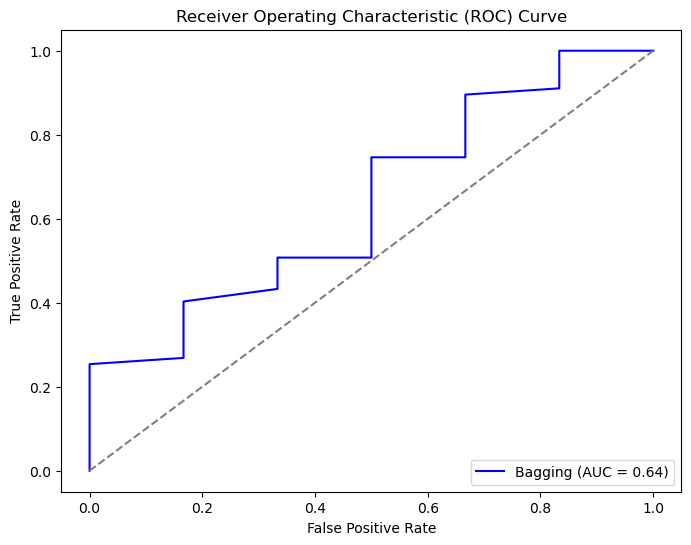

In [6]:
y_pred = bagging.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc_bagging = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Bagging (AUC = {roc_auc_bagging:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Now how does the ROC curve look? How does this compare to our classification accuracy metric?  What might be going on? 

Our model have high accuracy of 93%. When you look at the area under the curve, it is .64 which would suggest lest accuracy. This could be due to the class imbalance. It could be predicting the majority class better.

### Step 6: Introducing upsampling

The ROC curve indicates that our model is not performing well.  This is a common issue in imbalanced datasets, where one class significantly outnumbers the other. To improve our model’s ability to correctly classify both groups, we will upsample the minority class so that both classes have equal representation in the training set.

**Perform upsampling to balance the dataset**
1. Separate the majority and minority classes:
- Identify which class (0,1) is underrepresented (the minority class) and which is overrepresented (the majority class). 
- Separate both the `X_train` data and `y_train` data into all majority class and all minority class sets. 
2. Apply upsampling:
- Use `resample()` to create additional synthetic samples of the minority class *with replacement* until it is the same size as the majority class data. Use a random state of 808. 
3. Combine the balanced classes:
Merge the original majority class with the newly upsampled minority class.
4. Shuffle the resampled dataset:
- Randomly shuffle the data to ensure the model does not learn any unintended patterns from the order of the data. Use a random state of 808 for shuffling both the resampled X and y training data. 
5. Print the value counts for the resampled y training data to ensure that the data is balanced. 


In [7]:
# Separate majority and minority classes
X_train_majority = X_train[y_train == 1]
X_train_minority = X_train[y_train == 0]

y_train_majority = y_train[y_train == 1]
y_train_minority = y_train[y_train == 0]

X_train_minority_up = resample(X_train_minority,
                                random_state = 808,
                                n_samples=len(X_train_majority),
                                replace=True)
y_train_minority_up = resample(y_train_minority,
                                random_state = 808,
                                n_samples=len(y_train_majority),
                                replace=True)

X_train_balanced = pd.concat([X_train_majority, X_train_minority_up]).sample(frac = 1, random_state = 808).reset_index(drop = True)
y_train_balanced = pd.concat([y_train_majority, y_train_minority_up]).sample(frac = 1, random_state = 808).reset_index(drop = True)

X_train_balanced = resample(X_train_balanced, random_state=808)
y_train_balanced = resample(y_train_balanced, random_state=808)



print(f"Class distribution in balanced dataset:\n{y_train_balanced.value_counts()}")

Class distribution in balanced dataset:
Subarid
1    150
0    150
Name: count, dtype: int64


### Step 7: Retrain and evaluate model using balanced data

Now that we have addressed the class imbalance by upsampling the minority class, we will retrain the bagging classifier on the newly balanced dataset and evaluate its performance. This will help us determine whether handling class imbalance improves model accuracy and its ability to distinguish between classes. Create a bagging model using your balanced data. Use a random state of 808. Print the accuracy and and ROC Curve for this new model with balanced data. 

OOB Score (Balanced): 0.957
Bagging Accuracy (Balanced): 0.795


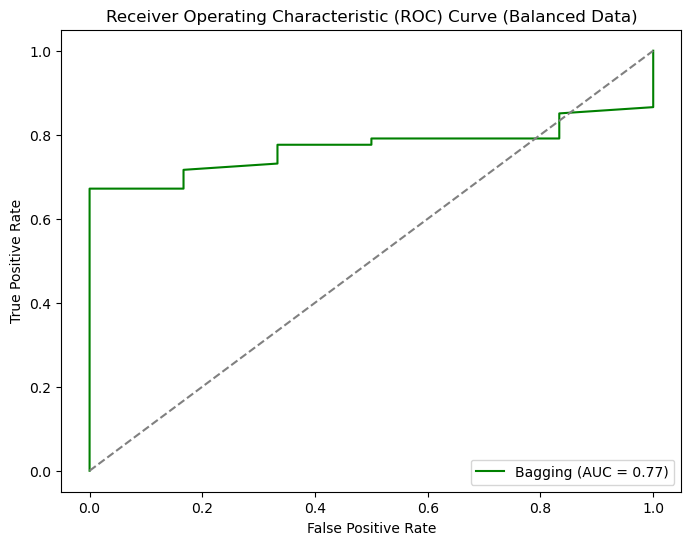

In [8]:
# Retrain the bagging classifier using the balanced data
bagging_balanced = BaggingClassifier(
        oob_score=True,
        n_estimators=100,
        bootstrap=True,
        random_state=808
)

# Train the model
bagging_balanced.fit(X_train_balanced, y_train_balanced)

# Generate predictions using the balanced model
bagging_balanced_preds = bagging_balanced.predict(X_test)

# Calculate the Out-of-Bag (OOB) Score
print(f"OOB Score (Balanced): {bagging_balanced.oob_score_ :.3f}")

# Compute model accuracy
balanced_accuracy = accuracy_score(y_test, bagging_balanced_preds)
print(f"Bagging Accuracy (Balanced): {balanced_accuracy :.3f}")

# Calculate and plot ROC curve
y_pred_balanced = bagging_balanced.predict_proba(X_test)[:,1]
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_pred_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_balanced, tpr_balanced, color='green', label=f'Bagging (AUC = {roc_auc_balanced:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Balanced Data)')
plt.legend(loc="lower right")
plt.show()

How did this second model, trained on balanced data, do in comparison to the first on the accuracy and AUC metrics.  How should we interpret those results?  Did the upscaling prove useful?

Accuracy went down and AUC went up. The increase in AUC means the model has improved its ability to discriminate between the minority and majority classes. This indicates better performance in ranking minority samples higher than majority ones, even though the overall classification accuracy has decreased

### Step 8: Analyzing feature importance with permutation importance

Understanding which bird traits contribute the most to our model’s predictions is crucial for interpreting results. We covered in lecture how the results of ensemble methods are harder to interpret than a single decision tree.  But we do have some tools to do it.  In this step, we will compute permutation importance, which measures the impact of each trait by shuffling its values and observing the effect on model performance. This will help us identify which functional traits—such as diet, body mass, or habitat breadth—play the biggest role in predicting whether a species is found in a subarid environment.

Use `permutation_importance()` to calculate the importance values.  You'll need to pass it the model, the feature and target test data, and an n_repeats value of 10.

In [9]:
# Calculate permutation importance
perm_importance = permutation_importance(
    bagging_balanced, X_test, y_test, n_repeats=10, random_state=808
)

# Create a DataFrame to store importance values
feature_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Print the feature importance values
print(feature_importance)

               Feature  Importance
10       ActivityCycle    0.043836
0        AdultBodyMass    0.027397
12     MigratoryStatus    0.019178
7          Diet_Plants    0.015068
14          ClutchSize    0.010959
16            EggWidth    0.009589
19        MaxLongevity    0.008219
18        NestingHabit    0.002740
3     Diet_Vertebrates    0.001370
2   Diet_Invertebrates    0.000000
4          Diet_Fruits    0.000000
5         Diet_Flowers    0.000000
9         TrophicLevel    0.000000
6           Diet_Seeds    0.000000
11     ForagingStratum   -0.001370
1          DietBreadth   -0.010959
15           EggLength   -0.010959
8           Diet_Other   -0.016438
13      IncubationTime   -0.019178
17             EggMass   -0.047945


What features are most important in our model of species distribution?

1. ActivityCylce
2. AdultBodyMass
3. MigratoryStatus
